<div align="center">

# National Tsing Hua University

### Fall 2023

#### 11210IPT 553000

#### Deep Learning in Biomedical Optical Imaging

## Report
</div>


In [1]:
# Download train and val dataset
!wget -q -O report_train.npy "https://www.dropbox.com/scl/fi/30dlbblp7wytcvoy05col/report_train.npy?rlkey=jx100qoz5n1d654v2mi32i9aj&dl=1"
!wget -q -O report_val.npy "https://www.dropbox.com/scl/fi/oo6g1yqhbjm22wffeddgv/report_val.npy?rlkey=9rqe0rucjhrbzv3x7xbs5047z&dl=1"

## A. Data Loading and Preprocessing

In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np

# Load Dataset
x_train = np.transpose(np.load('report_train.npy'), (0, 3, 1, 2))
x_val = np.transpose(np.load('report_val.npy'), (0, 3, 1, 2))

print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_val: {x_val.shape}')

num_classes = 6

# Create labels
y_train = np.concatenate([np.full(425, i) for i in range(num_classes)]) #425images for each class
y_val = np.concatenate([np.full(100, i) for i in range(num_classes)])

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()

x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).long()

Shape of x_train: (2550, 3, 150, 150)
Shape of x_val: (600, 3, 150, 150)


In [3]:
batch_size = 32

# Create datasets
train_dataset = TensorDataset(x_train , y_train)
val_dataset = TensorDataset(x_val, y_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


## B. Defining Neural Networks

In [4]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [17]:
from torchvision.ops.deform_conv import DeformConv2d
import torchvision.models as models
from torchvision.models.resnet import ResNet, BasicBlock
from torchvision import transforms

poolsize=1

class MyResNet18(ResNet):
    def __init__(self):
        super(MyResNet18, self).__init__(BasicBlock, [3,4,6,3])
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # change forward here
        x = transforms.functional.crop( x, 0, 0, height=128, width=128)
        #x = F.interpolate(x, scale_factor=0.25) #512
        #x = F.interpolate(x, scale_factor=4) #
        x = self.conv1(x)  #64*64
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x) #64*32
        x = self.layer1(x)  #64*32
        x = self.layer2(x)  #128*16
        x = self.layer3(x)  #256*8
        x = self.layer4(x)  #512*4
        x = self.avgpool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.dropout(x)
        x = self.fc(x)

        return x

model = MyResNet18()
model1 = models.resnet34(weights='IMAGENET1K_V1')
model.conv1 = model1.conv1
model.layer1=model1.layer1
model.layer2=model1.layer2
model.layer3=model1.layer3
model.layer4=model1.layer4

for param in model.parameters():
    param.requires_grad = True
#False: frozen except for the last ‘fc’ layer, which you have modified.

model.avgpool = nn.AdaptiveAvgPool2d(output_size=(poolsize, poolsize))  #8*8 -> poolsize*poolsize
num_ftrs = model.fc.in_features * poolsize * poolsize
model.fc = nn.Linear(num_ftrs, num_classes)

model.cuda()
print(model)

MyResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

## C. Training the Neural Network

In [18]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from tqdm.auto import tqdm
import time

train_losses = []
val_losses = []
test_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []
train_time=0
valid_time=0

epochs = 100

best_avg_loss = 100000000000
best_val_loss = float('inf')
best_val_acc = -1

criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#lr_scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=len(train_loader), eta_min=0)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0
    start = time.time()

    for images, labels in train_loader:
        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()


        optimizer.step()
        total_loss += loss.item()
        train_predicted = outputs.argmax(-1)
        train_correct += (train_predicted.float() == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples
    train_time+=time.time()-start

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    start = time.time()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            labels = labels.cuda()
            outputs = model(images)
            labels = labels.long()
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            predicted = outputs.argmax(-1)
            correct += (predicted.float() == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total
    valid_time+=time.time()-start

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'model_classification.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.2f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.2f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
print(train_time,valid_time)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train loss: 0.8590, Train acc: 71.53%, Val loss: 1.7550, Val acc: 66.17%, Best Val loss: 1.7550 Best Val acc: 66.17%
Epoch 2/100, Train loss: 0.5209, Train acc: 81.49%, Val loss: 0.5325, Val acc: 81.33%, Best Val loss: 0.5325 Best Val acc: 81.33%
Epoch 3/100, Train loss: 0.4849, Train acc: 82.35%, Val loss: 0.4744, Val acc: 80.50%, Best Val loss: 0.4744 Best Val acc: 81.33%
Epoch 4/100, Train loss: 0.3828, Train acc: 87.96%, Val loss: 0.8687, Val acc: 73.33%, Best Val loss: 0.4744 Best Val acc: 81.33%
Epoch 5/100, Train loss: 0.3533, Train acc: 88.43%, Val loss: 0.3561, Val acc: 86.83%, Best Val loss: 0.3561 Best Val acc: 86.83%
Epoch 6/100, Train loss: 0.3128, Train acc: 89.92%, Val loss: 0.6237, Val acc: 80.17%, Best Val loss: 0.3561 Best Val acc: 86.83%
Epoch 7/100, Train loss: 0.2580, Train acc: 90.98%, Val loss: 0.4077, Val acc: 85.83%, Best Val loss: 0.3561 Best Val acc: 86.83%
Epoch 8/100, Train loss: 0.2329, Train acc: 92.20%, Val loss: 0.4249, Val acc: 84.17%, Bes

In [ ]:
#save weight
torch.save(model.state_dict(), 'report_weight.pt')

### Visualizing model performance

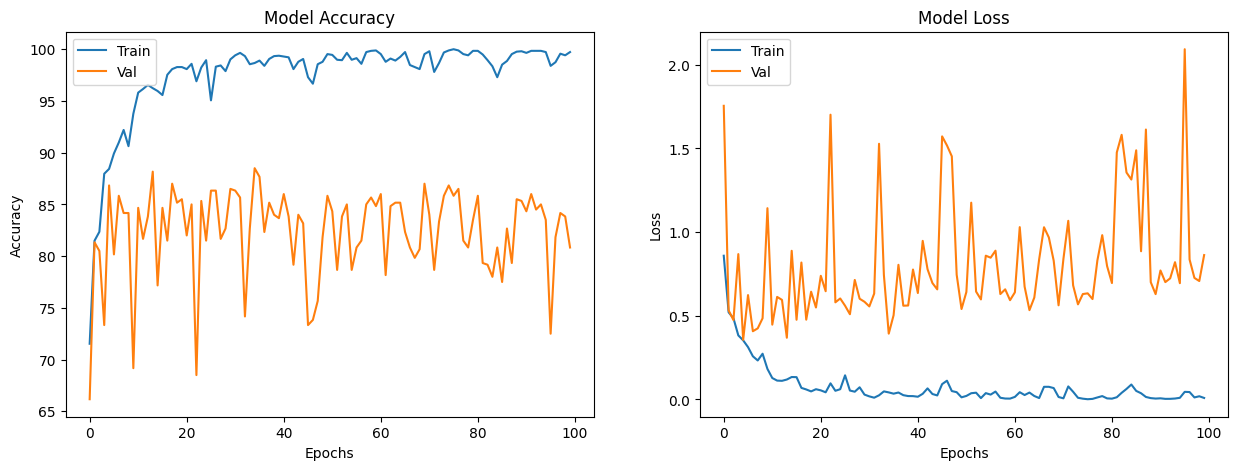

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

### Process Test Dataset

In [ ]:
# Download test dataset,
!wget -q -O report_test.npy "https://www.dropbox.com/scl/fi/ufcagx2cvjmervgqrgwrt/report_test.npy?rlkey=fijueom5x54628ivpzeki2bt0&dl=1"

In [ ]:
x_test = np.transpose(np.load('report_test.npy'), (0, 3, 1, 2))
print(f'Shape of x_test: {x_test.shape}')

y_test = np.concatenate([np.full(100, i) for i in range(num_classes)])

x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).long()

print(f'x_test: max value is {x_test.max().item()}, min value is {x_test.min().item()}, data type is {x_test.dtype}.')

batch_size = 32

# Combine the images and labels into a dataset
test_dataset = TensorDataset(x_test, y_test)

# Create a dataloader to load data in batches. Set batch size to 32.
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

Shape of x_test: (600, 3, 150, 150)
x_test: max value is 255.0, min value is 0.0, data type is torch.float32.


### Load Trained Model and Evaluate

In [ ]:
# Load the trained weights
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:

        images = images.cuda()

        labels = labels.cuda()
        labels = labels.long()

        outputs = model(images)

        predicted = outputs.argmax(-1)
        test_correct += (predicted.float() == labels).sum().item()
        test_total += labels.size(0)


print(f'Test accuracy is {100. * test_correct / test_total}%')

Test accuracy is 81.66666666666667%


In [ ]:
import csv
with open('res34 True pool2.csv', 'w') as f:

    # using csv.writer method from CSV package
    write = csv.writer(f)
    write.writerow(['train accuracies'])
    write.writerow(train_accuracies)
    write.writerow(['validation accuracy'])
    write.writerow(val_accuracies)
    write.writerow(['train loss'])
    write.writerow(train_losses)
    write.writerow(['validation loss'])
    write.writerow(val_losses)
    write.writerow(['training time(s)',train_time,'validation time(s)',valid_time])